# Traffic sign recognition - Nerual Net

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, Dense, Flatten
from keras.layers import Dropout, Activation, MaxPooling2D
from keras import activations

from sklearn import model_selection, metrics
from sklearn.utils import shuffle

import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from imageio import imread # Need 'Imageio' 'Pillow' packages
import cv2

from math import floor, ceil
import os

import h5py

Using TensorFlow backend.


# Load train data from German traffic sign database

In [2]:
# Use this if local
main_folder_path = "./German traffic sign dataset"

csv_content = [] # One numpy array per folder
                 # Each numpy array x: image y: proprierties

# Iterate over all subfolders to read the CSV file of each class
for i in range(43):
    train_dataset_path = main_folder_path + "/GTSRB_Training" + "/" + "{:05.0f}".format(i) + "/"
    f_name = train_dataset_path + "GT-" + "{:05.0f}".format(i) + ".csv"
    csv_content.append(np.genfromtxt(f_name, delimiter=';', skip_header=1, dtype=str))
print(csv_content[0][1,:])

['00000_00001.ppm' '30' '30' '5' '5' '25' '25' '0']


In [3]:
# Load the images and respective class

image = []
img_num = 0
labels = np.empty(0)

for i in range(43):
    image_class = []
    train_dataset_path = main_folder_path + "/GTSRB_Training" + "/" + "{:05.0f}".format(i) + '/'
    for label_name in enumerate(csv_content[i][:,0]):
        image_class.append(imread(train_dataset_path + label_name[1])[:,:,0]*0.2989+ # Adding image
                           imread(train_dataset_path + label_name[1])[:,:,1]*0.5870+ # with color
                           imread(train_dataset_path + label_name[1])[:,:,2]*0.1140) # adjusted by filtering
        labels = np.append(labels, i) # Appending image class based on folder
        img_num += 1
    image.append(image_class)

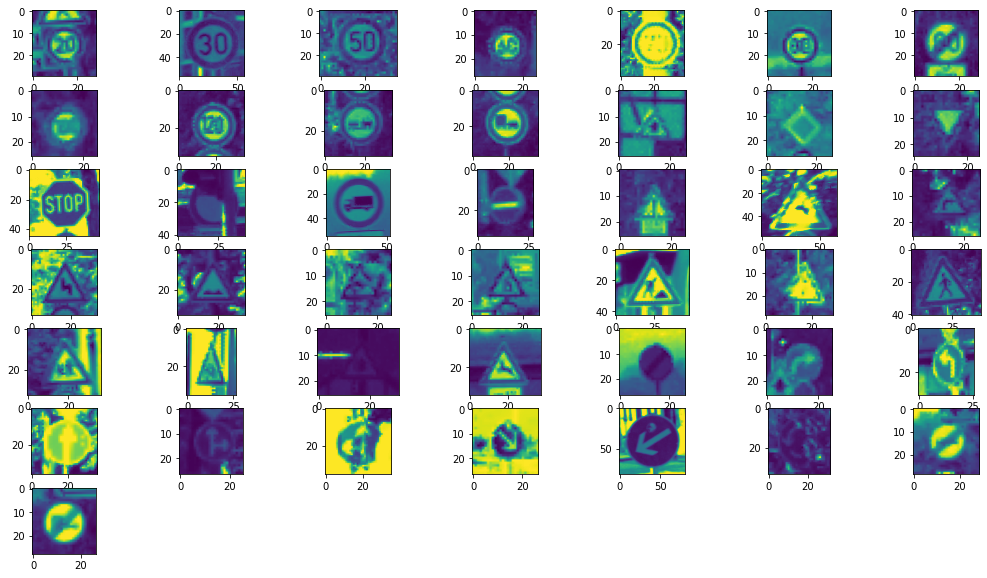

In [4]:
# Print the first image in every class

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in enumerate(image):
    ax0 = fig.add_subplot(gs[i[0]//7, i[0]%7])
    ax0.imshow(i[1][0])
    
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

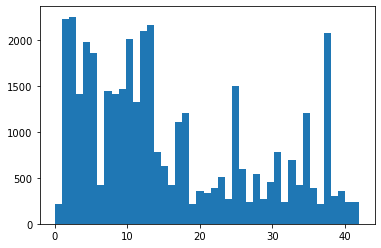

In [5]:
# Histogram of class population
plt.hist(labels, len(image))
plt.show

## Adapting the images

In [6]:
# Reshape training set
x_size = 32
y_size = 32
img_train = np.empty((img_num, x_size, y_size))

elaborated = 0

for image_set in enumerate(image):
    for image_array in enumerate(image_set[1]):
        # Cutting the image to match the content
        x2 = int(csv_content[image_set[0]][image_array[0], 5]) 
        x1 = int(csv_content[image_set[0]][image_array[0], 3])
        y2 = int(csv_content[image_set[0]][image_array[0], 6]) 
        y1 = int(csv_content[image_set[0]][image_array[0], 4])
        size = max(x2-x1, y2-y1)
        # Padding to have square images
        padded = np.pad(np.asarray(image_array[1][x1:x2, y1:y2]), \
                        ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                         (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
        # Reshaping the image to match the selected dimension
        reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
        # Copying the image inside the output array
        np.copyto(img_train[elaborated,:,:], reshaped)
        # Showing result
        #plt.imshow(img_train[elaborated,:,:])
        #plt.show()
        #Images should be one after another to train the model
        elaborated += 1

In [7]:
# Reshaping the train data to have a correct fit input
img_train_rsh = np.reshape(img_train, (img_train.shape[0], img_train.shape[1], img_train.shape[2],1))

# Loading test data

In [8]:
# Use this if no test data supplied

# Split train and validation data from the train dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(img_train_rsh, labels, test_size=0.25)
print(x_train.shape[0], x_test.shape[0], y_train.shape[0], y_test.shape[0])

29406 9803 29406 9803


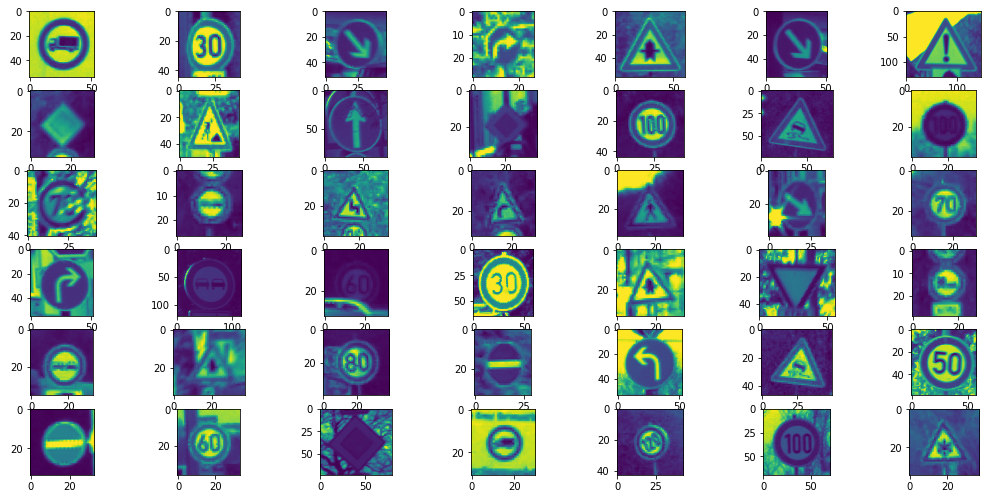

In [9]:
# Run this section if test data are supplied - more image to train classifier
main_folder_path = "./German traffic sign dataset"

# Adapting test data to network input dimension from data dataset
x_size = 32
y_size = 32
test_dataset_path = main_folder_path + "/GTSRB_Testing"

test_csv = (np.genfromtxt(test_dataset_path  + "/GT-final_test.csv", delimiter=';', skip_header=1, dtype=str))

image_test = []

for name_img in test_csv:
    image_test.append(imread(test_dataset_path + "/" + name_img[0])[:,:,0]*0.2989+
                      imread(test_dataset_path + "/" + name_img[0])[:,:,1]*0.5870+
                      imread(test_dataset_path + "/" + name_img[0])[:,:,2]*0.1140)
    
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in range(42):
    ax0 = fig.add_subplot(gs[i//7, i%7])
    ax0.imshow(image_test[i])

plt.show()       

# Count total number of images:
img_test_num = len(image_test)
                                 
# Reshape test set
img_test = np.empty((img_test_num, x_size, y_size))

for image_set in enumerate(image_test):
    # Cutting the image to match the content
    x2 = int(test_csv[image_set[0], 5]) 
    x1 = int(test_csv[image_set[0], 3])
    y2 = int(test_csv[image_set[0], 6]) 
    y1 = int(test_csv[image_set[0], 4])
    size = max(x2-x1, y2-y1)
    # Padding to have square images
    padded = np.pad(np.asarray(image_set[1][x1:x2, y1:y2]), \
                    ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                     (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
    # Reshaping the image to match the selected dimension
    reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
    # Copying the image inside the output array
    np.copyto(img_test[image_set[0],:,:], reshaped)

img_test_rsh = np.reshape(img_test, (img_test.shape[0], img_test.shape[1], img_test.shape[2],1))
    
x_train, y_train = shuffle(img_train_rsh, labels)

x_test = img_test_rsh
y_test = test_csv[:, 7].astype(np.int64)

In [10]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, len(image))
Y_test = to_categorical(y_test, len(image))

In [11]:
print(x_train.shape, x_test.shape, Y_train.shape, Y_test.shape)

(39209, 32, 32, 1) (12630, 32, 32, 1) (39209, 43) (12630, 43)


# Creating optimized model

In [12]:
model_s = Sequential()
#model_s.add(InputLayer(input_shape=(x_size, y_size, 1)))
model_s.add(Conv2D(10, (7,7), strides=(1,1), input_shape=(x_size, y_size, 1)))
model_s.add(Activation(activations.relu))
model_s.add(MaxPooling2D(pool_size=(2,2)))
model_s.add(Conv2D(50, (4,4), strides=(1,1)))
model_s.add(Activation(activations.relu))
model_s.add(MaxPooling2D(pool_size=(2,2)))
model_s.add(Conv2D(100, (4,4), strides=(1,1)))
model_s.add(Activation(activations.relu))
model_s.add(MaxPooling2D(pool_size=(2,2)))
model_s.add(Flatten())
model_s.add(Dense(100))
model_s.add(Activation(activations.relu))
model_s.add(Dense(43))
model_s.add(Activation(activations.softmax))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [13]:
#x_train /= 255
model_s.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_s.fit(x_train, Y_train, batch_size=50, epochs=10, verbose=1)


Epoch 1/10
39209/39209 [==============================] - 34s 879us/step - loss: 1.0739 - accuracy: 0.7752
Epoch 2/10
39209/39209 [==============================] - 66s 2ms/step - loss: 0.1772 - accuracy: 0.9609
Epoch 3/10
39209/39209 [==============================] - 74s 2ms/step - loss: 0.1085 - accuracy: 0.9748
Epoch 4/10
39209/39209 [==============================] - 39s 992us/step - loss: 0.1113 - accuracy: 0.9748
Epoch 5/10
39209/39209 [==============================] - 61s 2ms/step - loss: 0.0779 - accuracy: 0.9819
Epoch 6/10
39209/39209 [==============================] - 95s 2ms/step - loss: 0.0712 - accuracy: 0.9837
Epoch 7/10
39209/39209 [==============================] - 57s 1ms/step - loss: 0.0640 - accuracy: 0.9855 0s - loss: 0.0634 - 
Epoch 8/10
39209/39209 [==============================] - 56s 1ms/step - loss: 0.0668 - accuracy: 0.9853
Epoch 9/10
39209/39209 [==============================] - 70s 2ms/step - loss: 0.0572 - accuracy: 0.9874- ETA: 0s - loss: 0.0574 - 
Ep

## Testing and saving the model

In [14]:
#x_test /= 255
test_loss, test_acc = model_s.evaluate(x_test, Y_test)

print('\nTest accuracy:', test_acc)

12630/12630 [==============================] - 7s 540us/step

Test accuracy: 0.9258907437324524


[16  1 38 ...  6  7 10]
[16  1 38 ...  6  7 10]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.96      0.96      0.96       720
           2       0.98      0.97      0.97       750
           3       0.92      0.98      0.95       450
           4       0.96      0.98      0.97       660
           5       0.97      0.92      0.95       630
           6       0.95      0.81      0.87       150
           7       0.98      0.96      0.97       450
           8       0.97      0.95      0.96       450
           9       0.90      1.00      0.95       480
          10       1.00      0.95      0.97       660
          11       0.91      0.97      0.94       420
          12       0.91      0.98      0.94       690
          13       0.99      0.99      0.99       720
          14       1.00      0.86      0.93       270
          15       0.86      0.83      0.84       210
          16       1.00      0.99

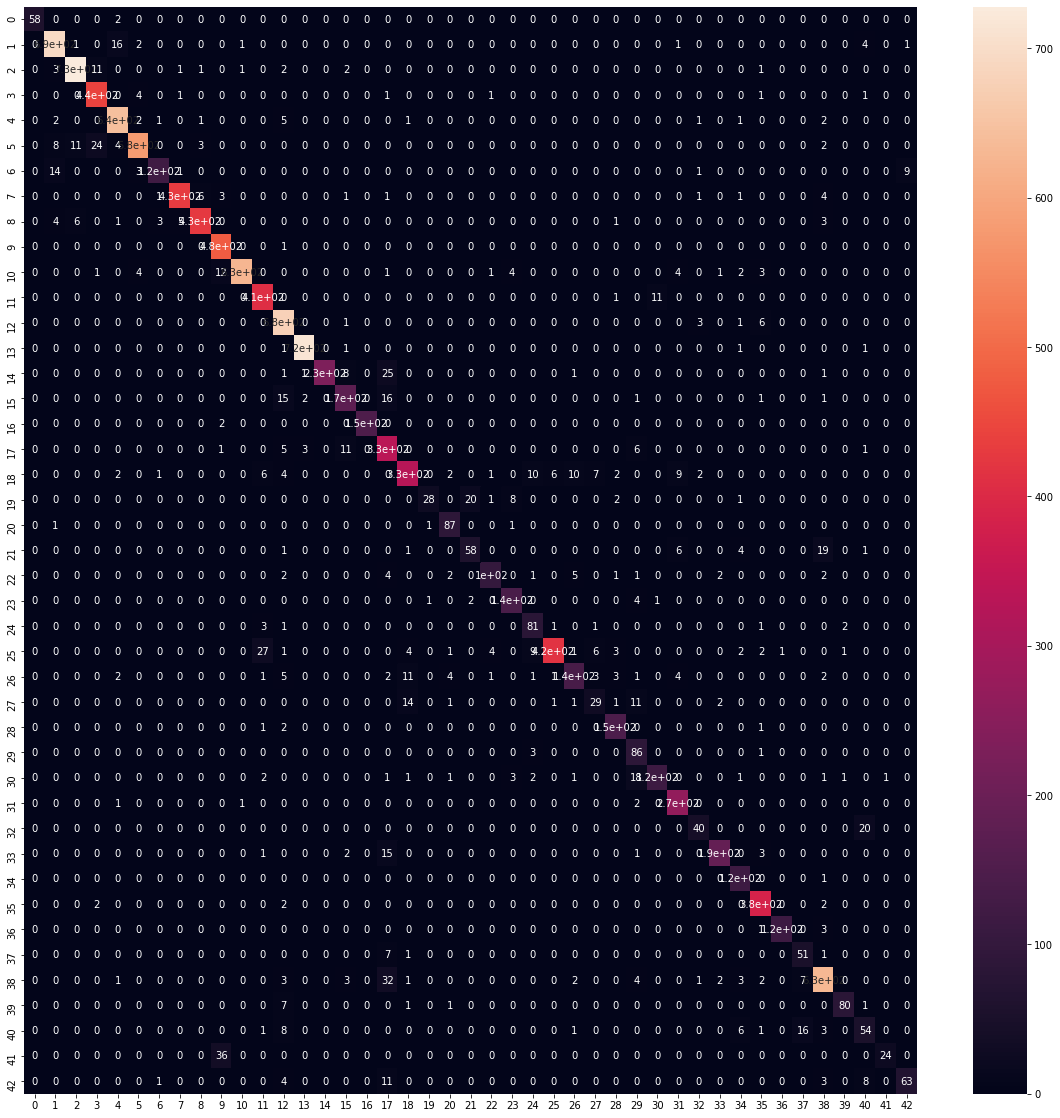

In [15]:
# Metrics and confusion matrix
y_pred = model_s.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
print(y_pred_class)
print(y_test.astype(np.int64))

report = metrics.classification_report(y_test, y_pred_class)
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_class)
print(report)

plt.subplots(figsize=(20,20))
sns.heatmap(confusion_matrix, annot=True)

In [16]:
model_s.save("./Models/model_s.h5")
print("Saved model to disk")

Saved model to disk


# Prepare test data

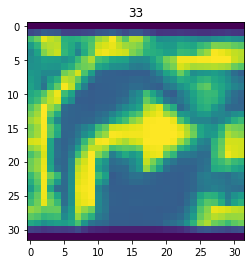

In [17]:
first_to_test = 3
n_to_test = 1

to_test = np.reshape(x_test[:,:,:], (-1,1024))

for i in range(n_to_test):
    plt.imshow(np.reshape(to_test[first_to_test,:], (32, 32)))
    plt.title(np.argmax(Y_test[first_to_test]))
    plt.show()
with open("./Test_data/image_arranged.csv", "w") as f:
    np.savetxt(f, to_test[first_to_test:first_to_test+n_to_test,:], delimiter=' ', fmt='%d')

with open("./Test_data/image_annotation.csv", "w") as f:
    np.savetxt(f, Y_test[first_to_test:first_to_test+n_to_test,:], delimiter=',', fmt='%d')